## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

## Task 2 : Loading VGG Pretrained Model

In [1]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
vgg = vgg.features

In [3]:
for parameter in vgg.parameters():
  parameter.requires_grad_(False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [6]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path).convert("RGB")
  size = min(max_size, max(image.size))

  img_transforms = T.Compose(
      [
          T.Resize(size),
          T.ToTensor(),
          T.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )
      ]
  )

  image = img_transforms(image)
  image = image.unsqueeze(0)
  return image

In [7]:
!ls Project-NST

69561.jpg  content10.jpg  representation.png  style10.jpg  style12.jpg
README.md  content11.jpg  spiderman.jpg       style11.jpg


## Task 4 : Deprocess image

In [8]:
content_p = preprocess("Project-NST/spiderman.jpg")
style_p = preprocess("Project-NST/style10.jpg")

content_p = content_p.to(device)
style_p = style_p.to(device)

print(content_p.shape)
print(style_p.shape)

torch.Size([1, 3, 500, 888])
torch.Size([1, 3, 500, 765])


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to("cpu").clone()
  image = image.detach().numpy()
  image = image.squeeze(0)
  image = image.transpose(1,2,0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

  return image

In [10]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print(content_d.shape)
print(style_d.shape)

(500, 888, 3)
(500, 765, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


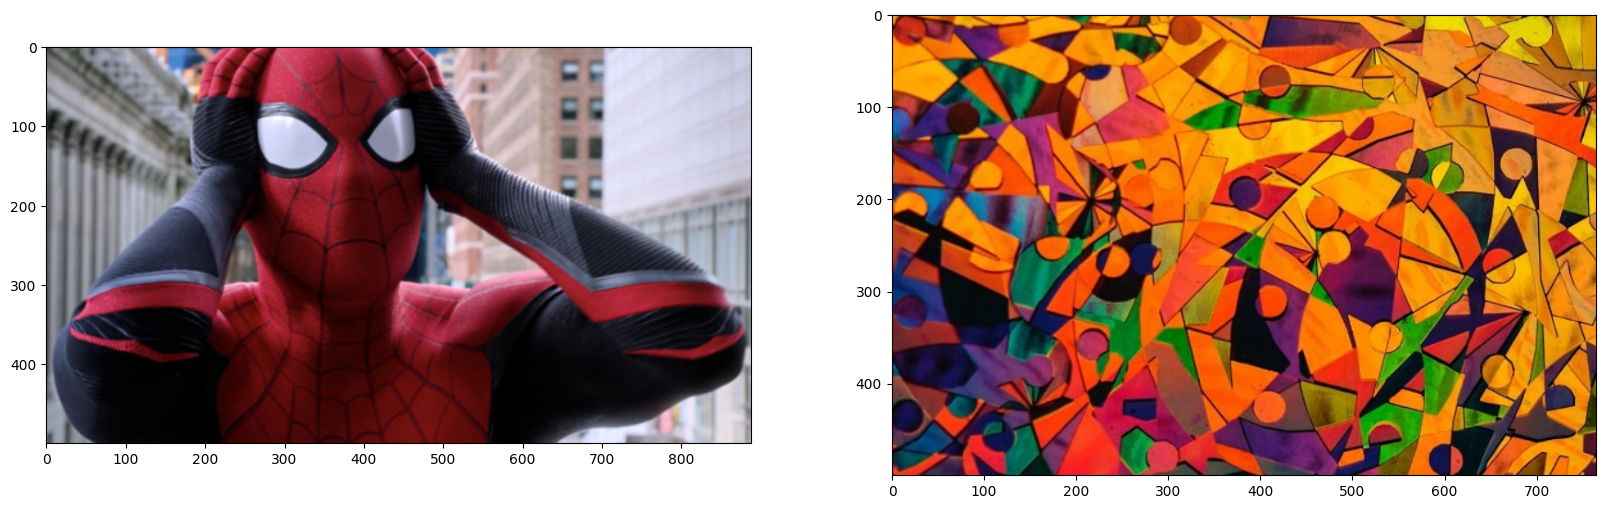

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(content_d)
ax2.imshow(style_d)

## Task 5 : Get content,style features and create gram matrix

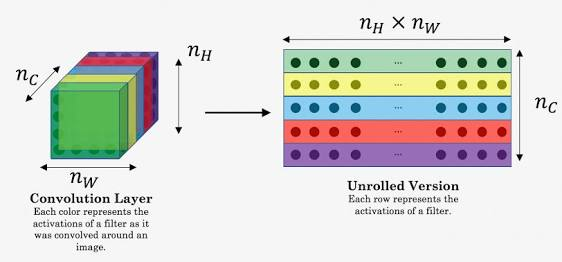

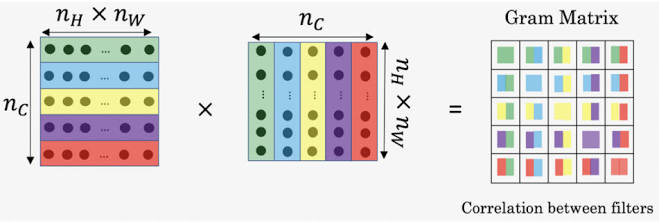

In [12]:
def get_features(image, model):
  layers = {
      "0": "conv1_1",
      "5": "conv2_1",
      "10": "conv3_1",
      "19": "conv4_1",
      "21": "conv4_2",
      "28": "conv5_1",
  }

  x = image
  Features = {}

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x

  return Features

In [13]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

In [14]:
def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())

  return gram

In [15]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [16]:
def content_loss(target_f, content_f):
  loss = torch.mean((target_f - content_f)**2)
  return loss

In [17]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,
}

In [18]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]

    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss


In [19]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
print(f"content loss: {content_loss(target_f['conv4_2'], content_f['conv4_2'])}")
print(f"style loss: {style_loss(style_weights, target_f, style_grams)}")

content loss: 0.0
style loss: 1083.0947265625


## Task 7 : Training loop

In [20]:
from torch import optim

optimizer = optim.Adam([target], lr=0.003)

# content reconstruction rate
alpha = 1
beta = 1e2

epochs = 3000
show_every = 500

In [21]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [22]:
results = []

for i in range(epochs):
  target_f = get_features(target, vgg)
  t_loss = total_loss(
      content_loss(target_f["conv4_2"], content_f["conv4_2"]),
      style_loss(style_weights, target_f, style_grams),
      alpha,
      beta
  )

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f"Total loss at epoch {i} : {t_loss}")
    results.append(deprocess(target))




Total loss at epoch 0 : 108309.46875
Total loss at epoch 500 : 15163.0908203125
Total loss at epoch 1000 : 5498.09423828125


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


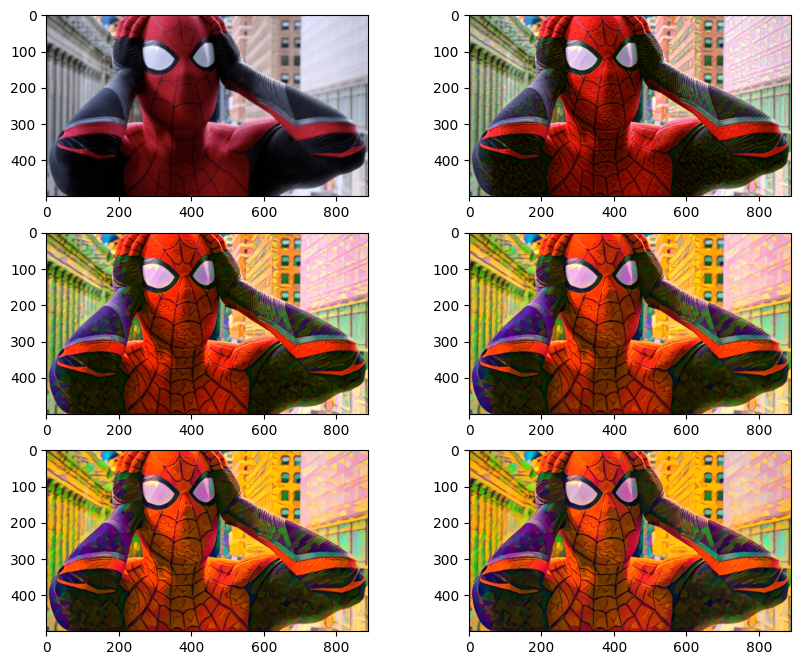

In [ ]:
plt.figure(figsize=(10,8))

for i in range(len(results)):
  plt.subplot(3, 2, i+1)
  plt.imshow(results[i])

plt.show()

In [26]:
from torch import nn

class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [28]:
from torch.optim import Adam

model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [29]:
# train

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [30]:
train(model, optimizer, epochs=50, device=device)

NameError: name 'train_loader' is not defined